## Example 2: Logistic regression

Import libraries

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.lines import Line2D

In [2]:
SEED = 1234
az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 300

Read data

In [3]:
data = bmb.load_data("ANES")
print(data.shape)
data.head()

(421, 3)


,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Subset data

In [4]:
data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
print(data.shape)
data.head()

(373, 3)


,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Fit model

In [5]:
model = bmb.Model("vote[clinton] ~ party_id + party_id:scale(age)", data, family="bernoulli")
model

Formula: vote[clinton] ~ party_id + party_id:scale(age)
Family name: Bernoulli
Link: logit
Observations: 373
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 3.294)
    party_id ~ Normal(mu: [0. 0.], sigma: [5.4007 6.0634])
    party_id:scale(age) ~ Normal(mu: [0. 0. 0.], sigma: [3.6348 4.5568 5.2877])

In [6]:
idata = model.fit(tune=2000, draws=2000, chains=4, random_seed=SEED)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [party_id:scale(age), party_id, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 21 seconds.


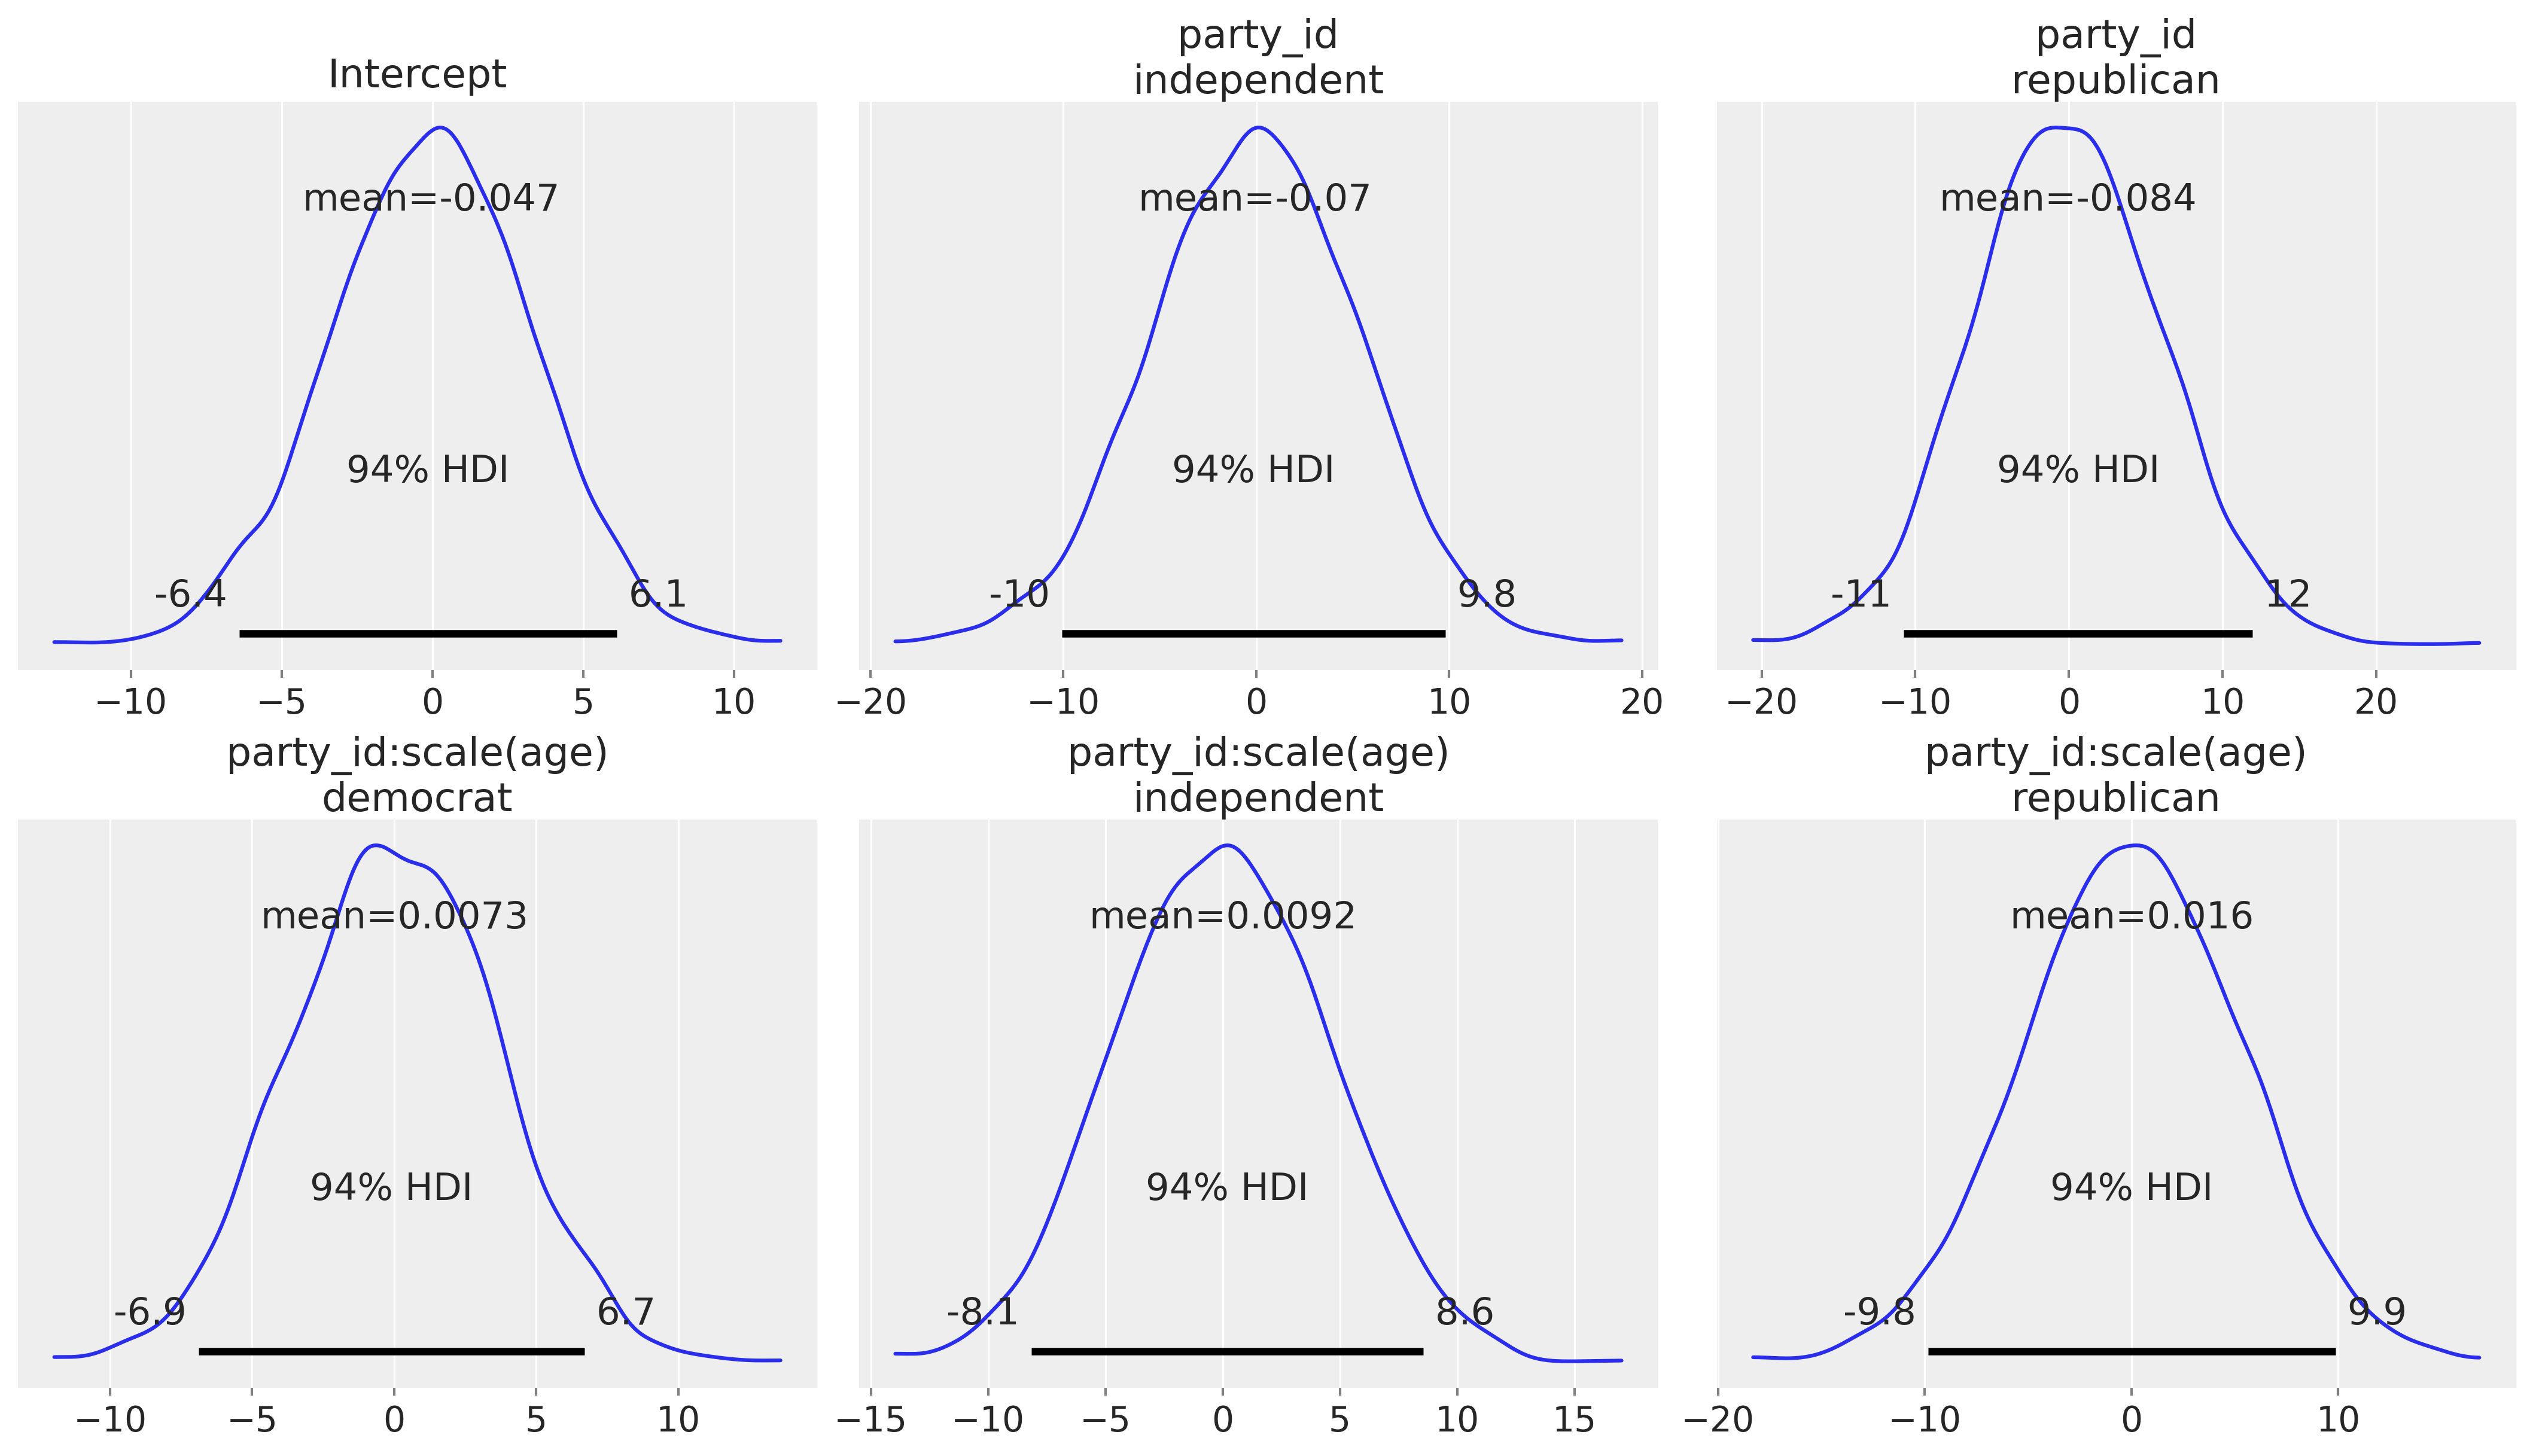

In [7]:
model.plot_priors(figsize = (14, 8));
plt.savefig("imgs/clinton_prior.pdf")

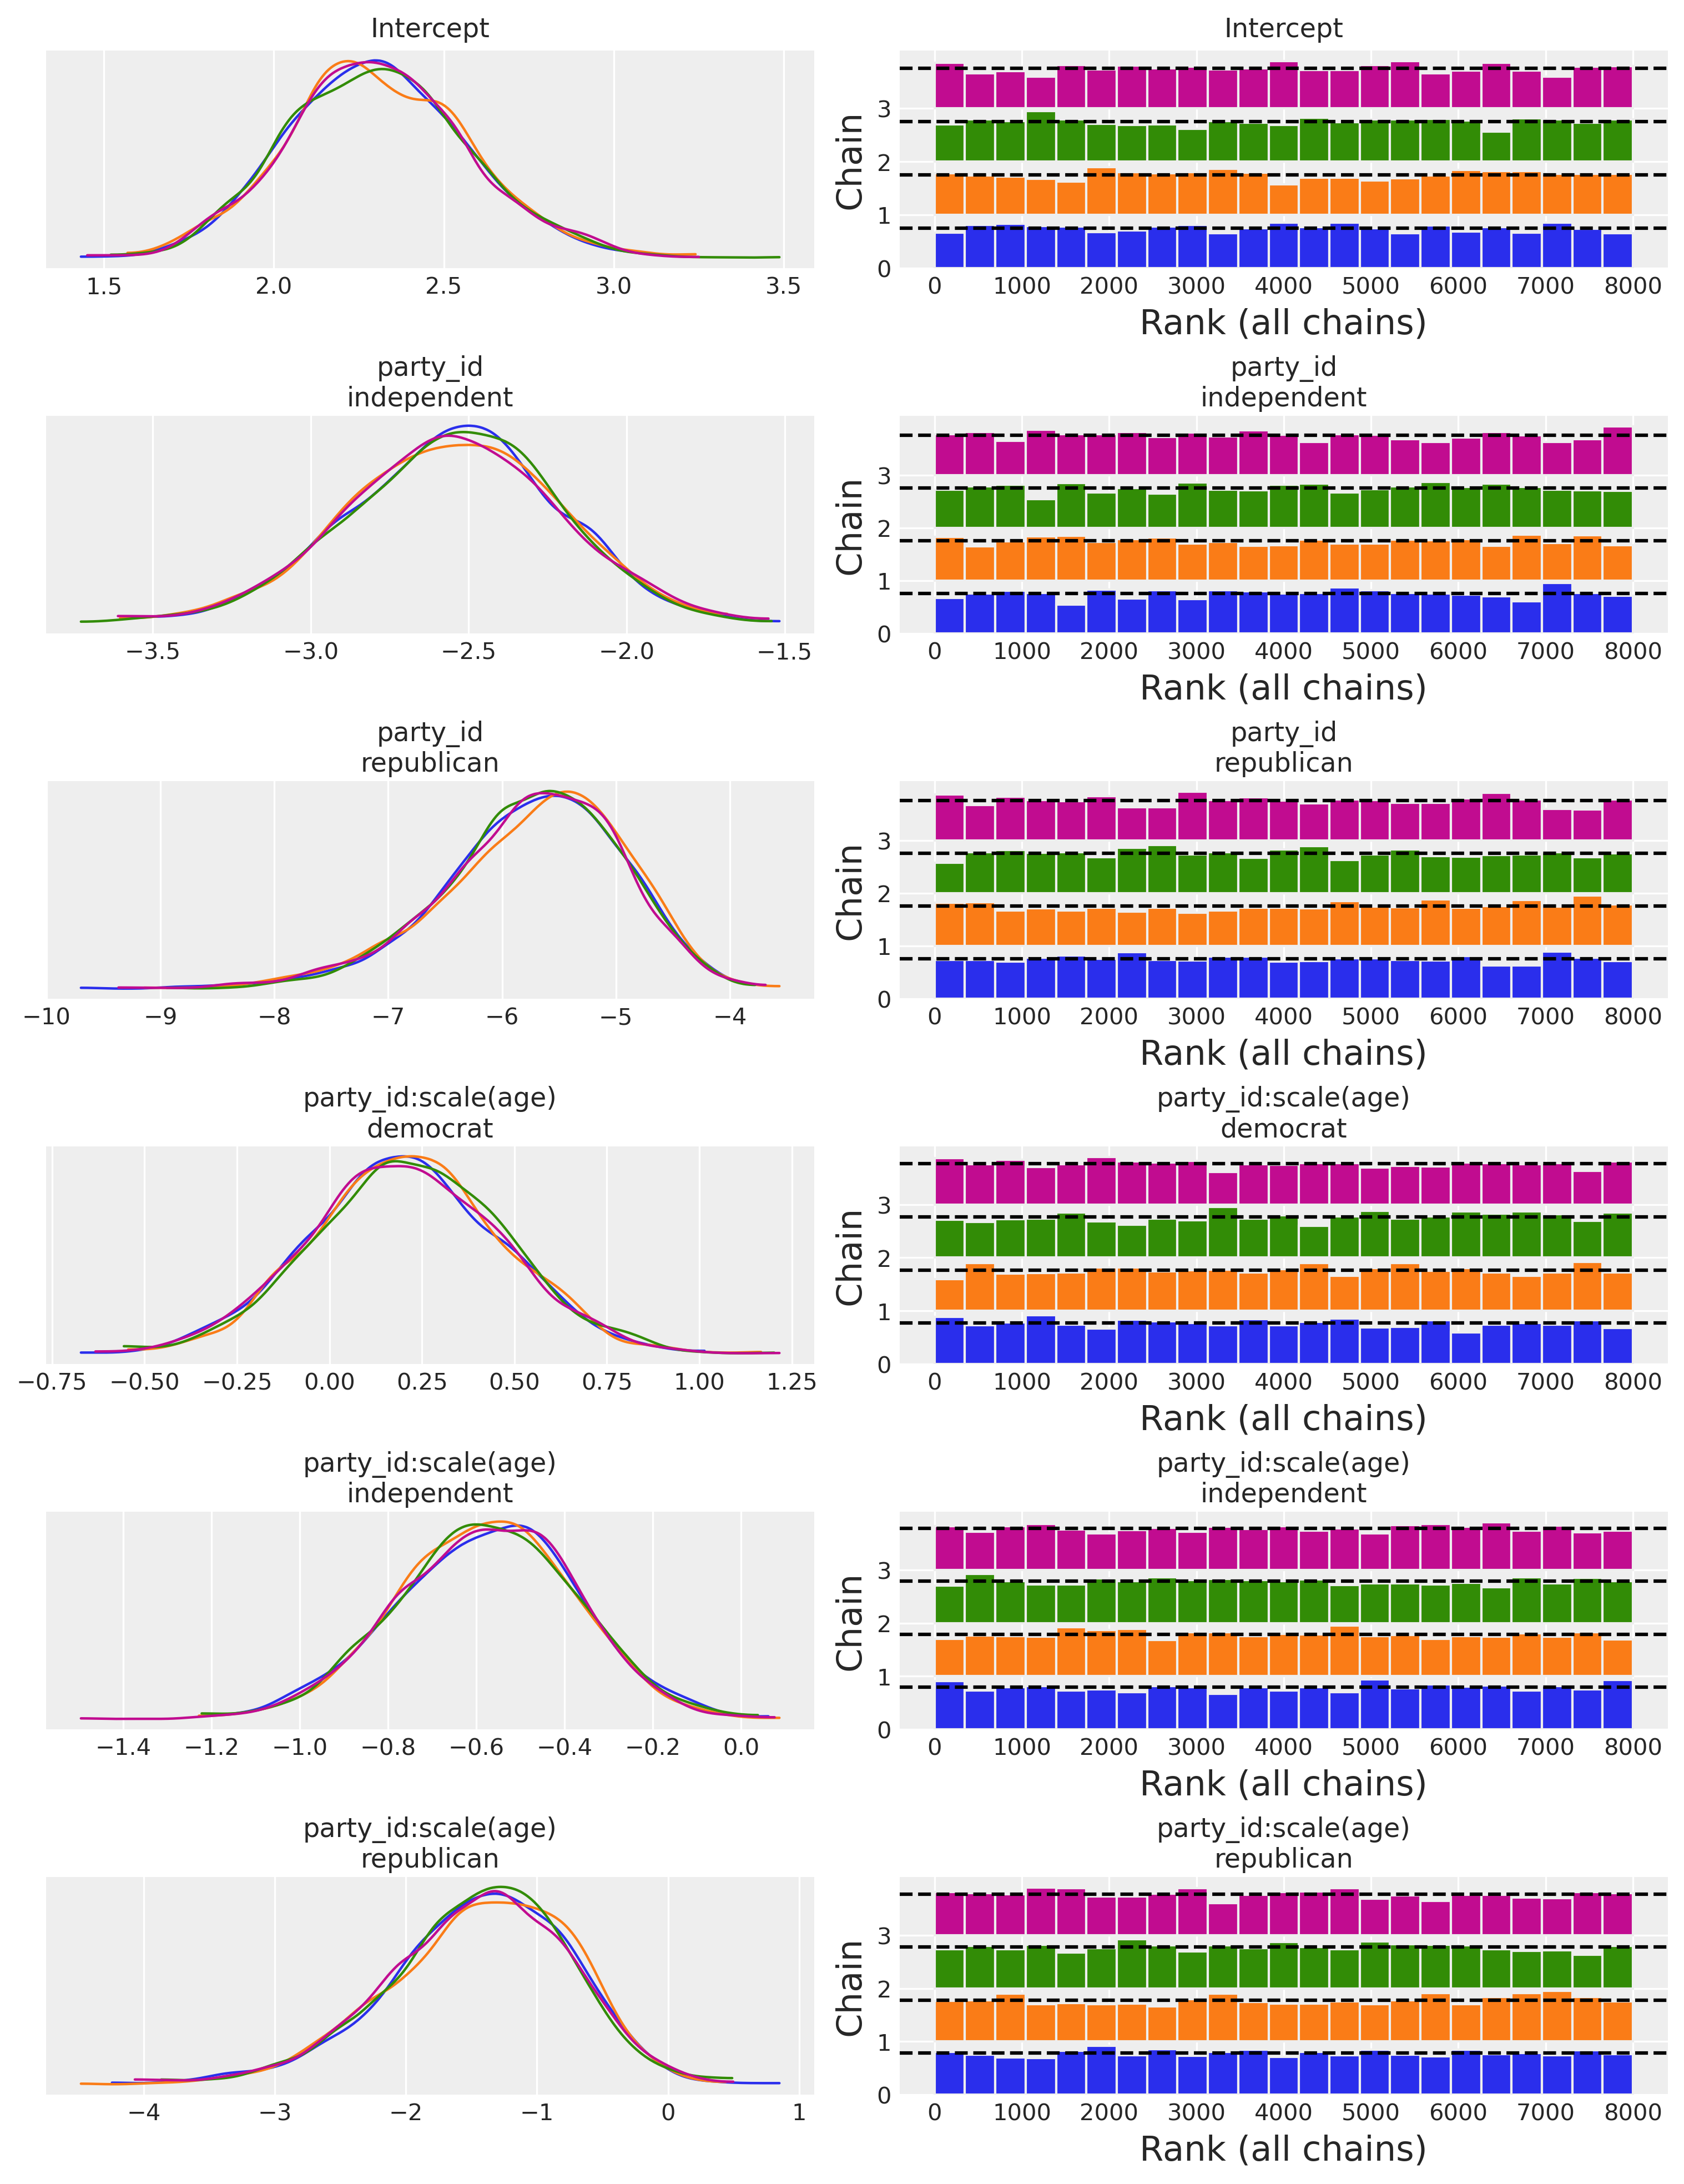

In [8]:
az.plot_trace(idata, compact=False, kind="rank_bars", figsize=(10, 13));
plt.savefig("imgs/clinton_posterior.pdf")

In [9]:
# Create a new dataset with age going from 18 to 90
age = np.arange(18, 91)
parties = ["democrat", "republican", "independent"]
new_data = pd.DataFrame({
    "age": np.tile(age, 3),
    "party_id": np.repeat(parties, len(age))
})
new_data

,age,party_id
0,18,democrat
1,19,democrat
2,20,democrat
3,21,democrat
4,22,democrat
...,...,...
214,86,independent
215,87,independent
216,88,independent
217,89,independent


In [10]:
# Predict mean of P(vote = clinton | age)
model.predict(idata, data=new_data)

# Compute mean across chains
posterior_mean = idata.posterior["vote_mean"].values.mean(0)

# Select 500 draws
# Transpose to get an array of shape (219, 500)
posterior_mean = posterior_mean[:500, :].T

/tmp/ipykernel_64243/634679484.py:14: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(top=0.925, left=0.1, right=0.95, bottom=0.1)


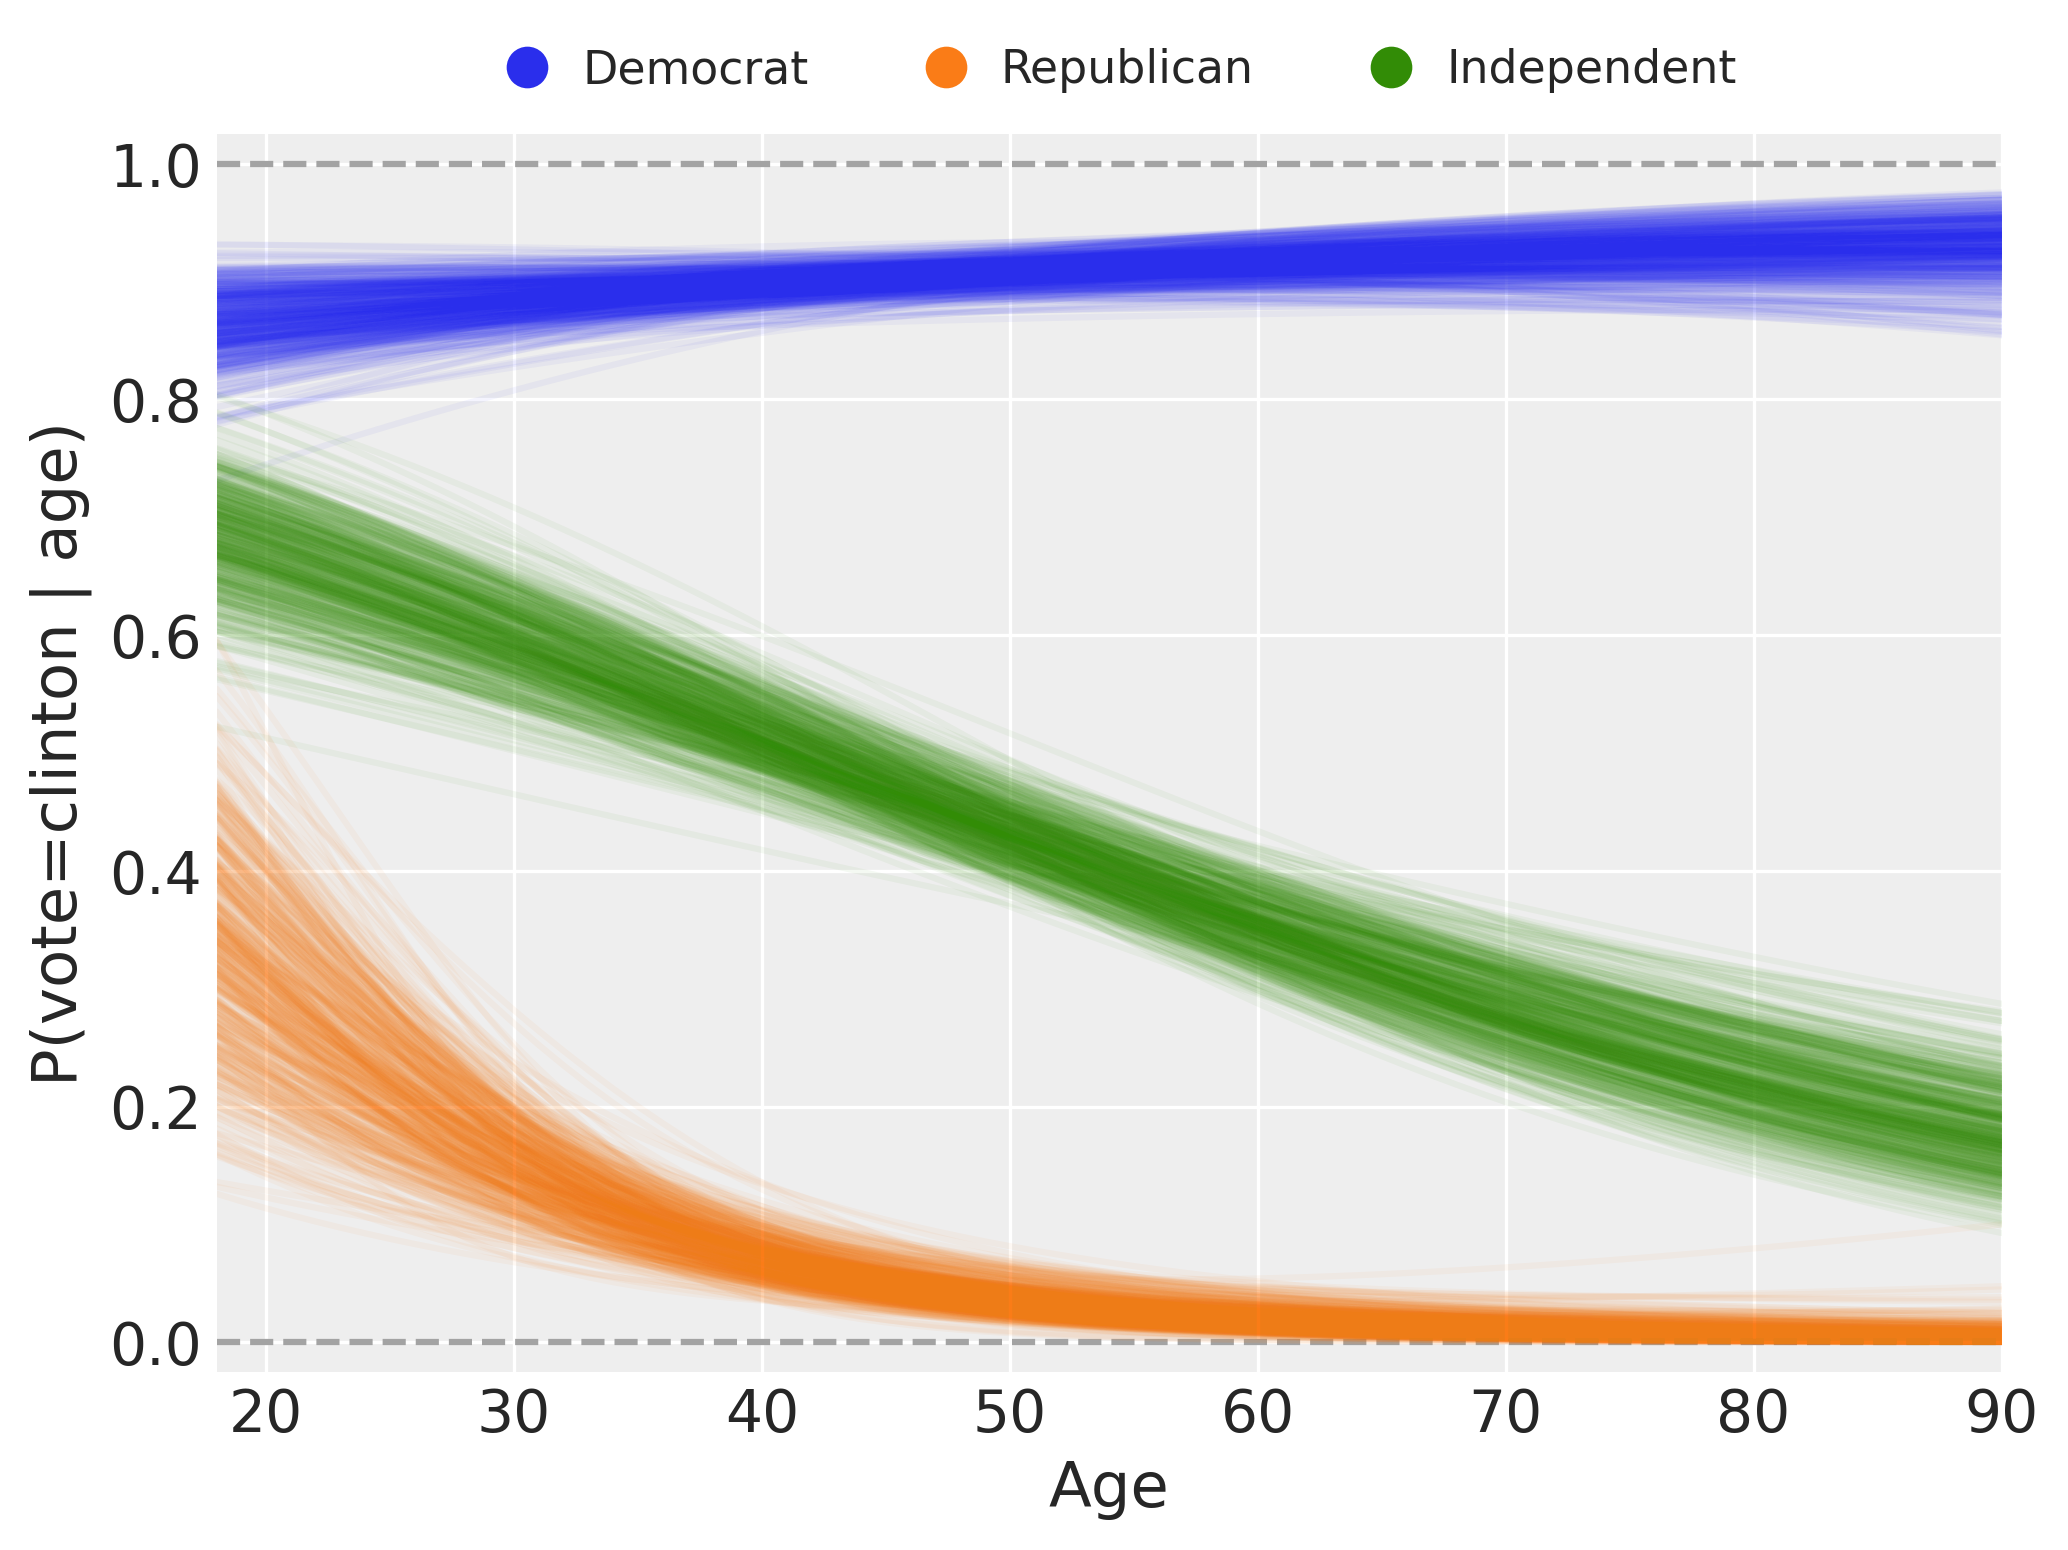

In [11]:
fig, ax = plt.subplots(figsize=(7, 5))

for i, party in enumerate(parties):
    idx = new_data.index[new_data["party_id"] == party]
    ax.plot(age, posterior_mean[idx], alpha=0.05, color=f"C{i}")

ax.axhline(y = 0, ls="--", color="#a3a3a3", zorder=1)
ax.axhline(y = 1, ls="--", color="#a3a3a3", zorder=1)
ax.set_ylabel("P(vote=clinton | age)")
ax.set_xlabel("Age", fontsize=15)
ax.set_ylim(-0.025, 1.025)
ax.set_xlim(18, 90)

fig.subplots_adjust(top=0.925, left=0.1, right=0.95, bottom=0.1)

labels = [party.capitalize() for party in parties]

# Create legend
handles = [
    Line2D(
        [0], [0], label=label, marker="o", color="None", 
        markerfacecolor=f"C{i}", markeredgewidth=0, markersize=10
    )
    for i, label in enumerate(labels)
]

# Add legend
x_center = 0.1 + (0.95 - 0.1) / 2 
legend = fig.legend(
    handles=handles, 
    ncol=5,
    loc="lower center",
    bbox_to_anchor=(x_center, 0.925),
    handletextpad=0.2,
    columnspacing=2,
    fontsize=11,
)

fig.savefig("imgs/clinton_results.pdf")    

## Not included

The following are computations and plots that ended up not included in the paper.

Computing the probability that the Democrat slope coefficient is bigger than the others:

In [12]:
party_idx = [0, 1, 2]
dem, ind, rep = [idata.posterior["party_id:scale(age)"][:, :, x].values for x in party_idx]

In [13]:
dem = dem.ravel()
rep = rep.ravel()
ind = ind.ravel()

In [14]:
print((dem > rep).mean())

0.994


In [15]:
print((dem > ind).mean())

0.992875


Same comparison but visually:

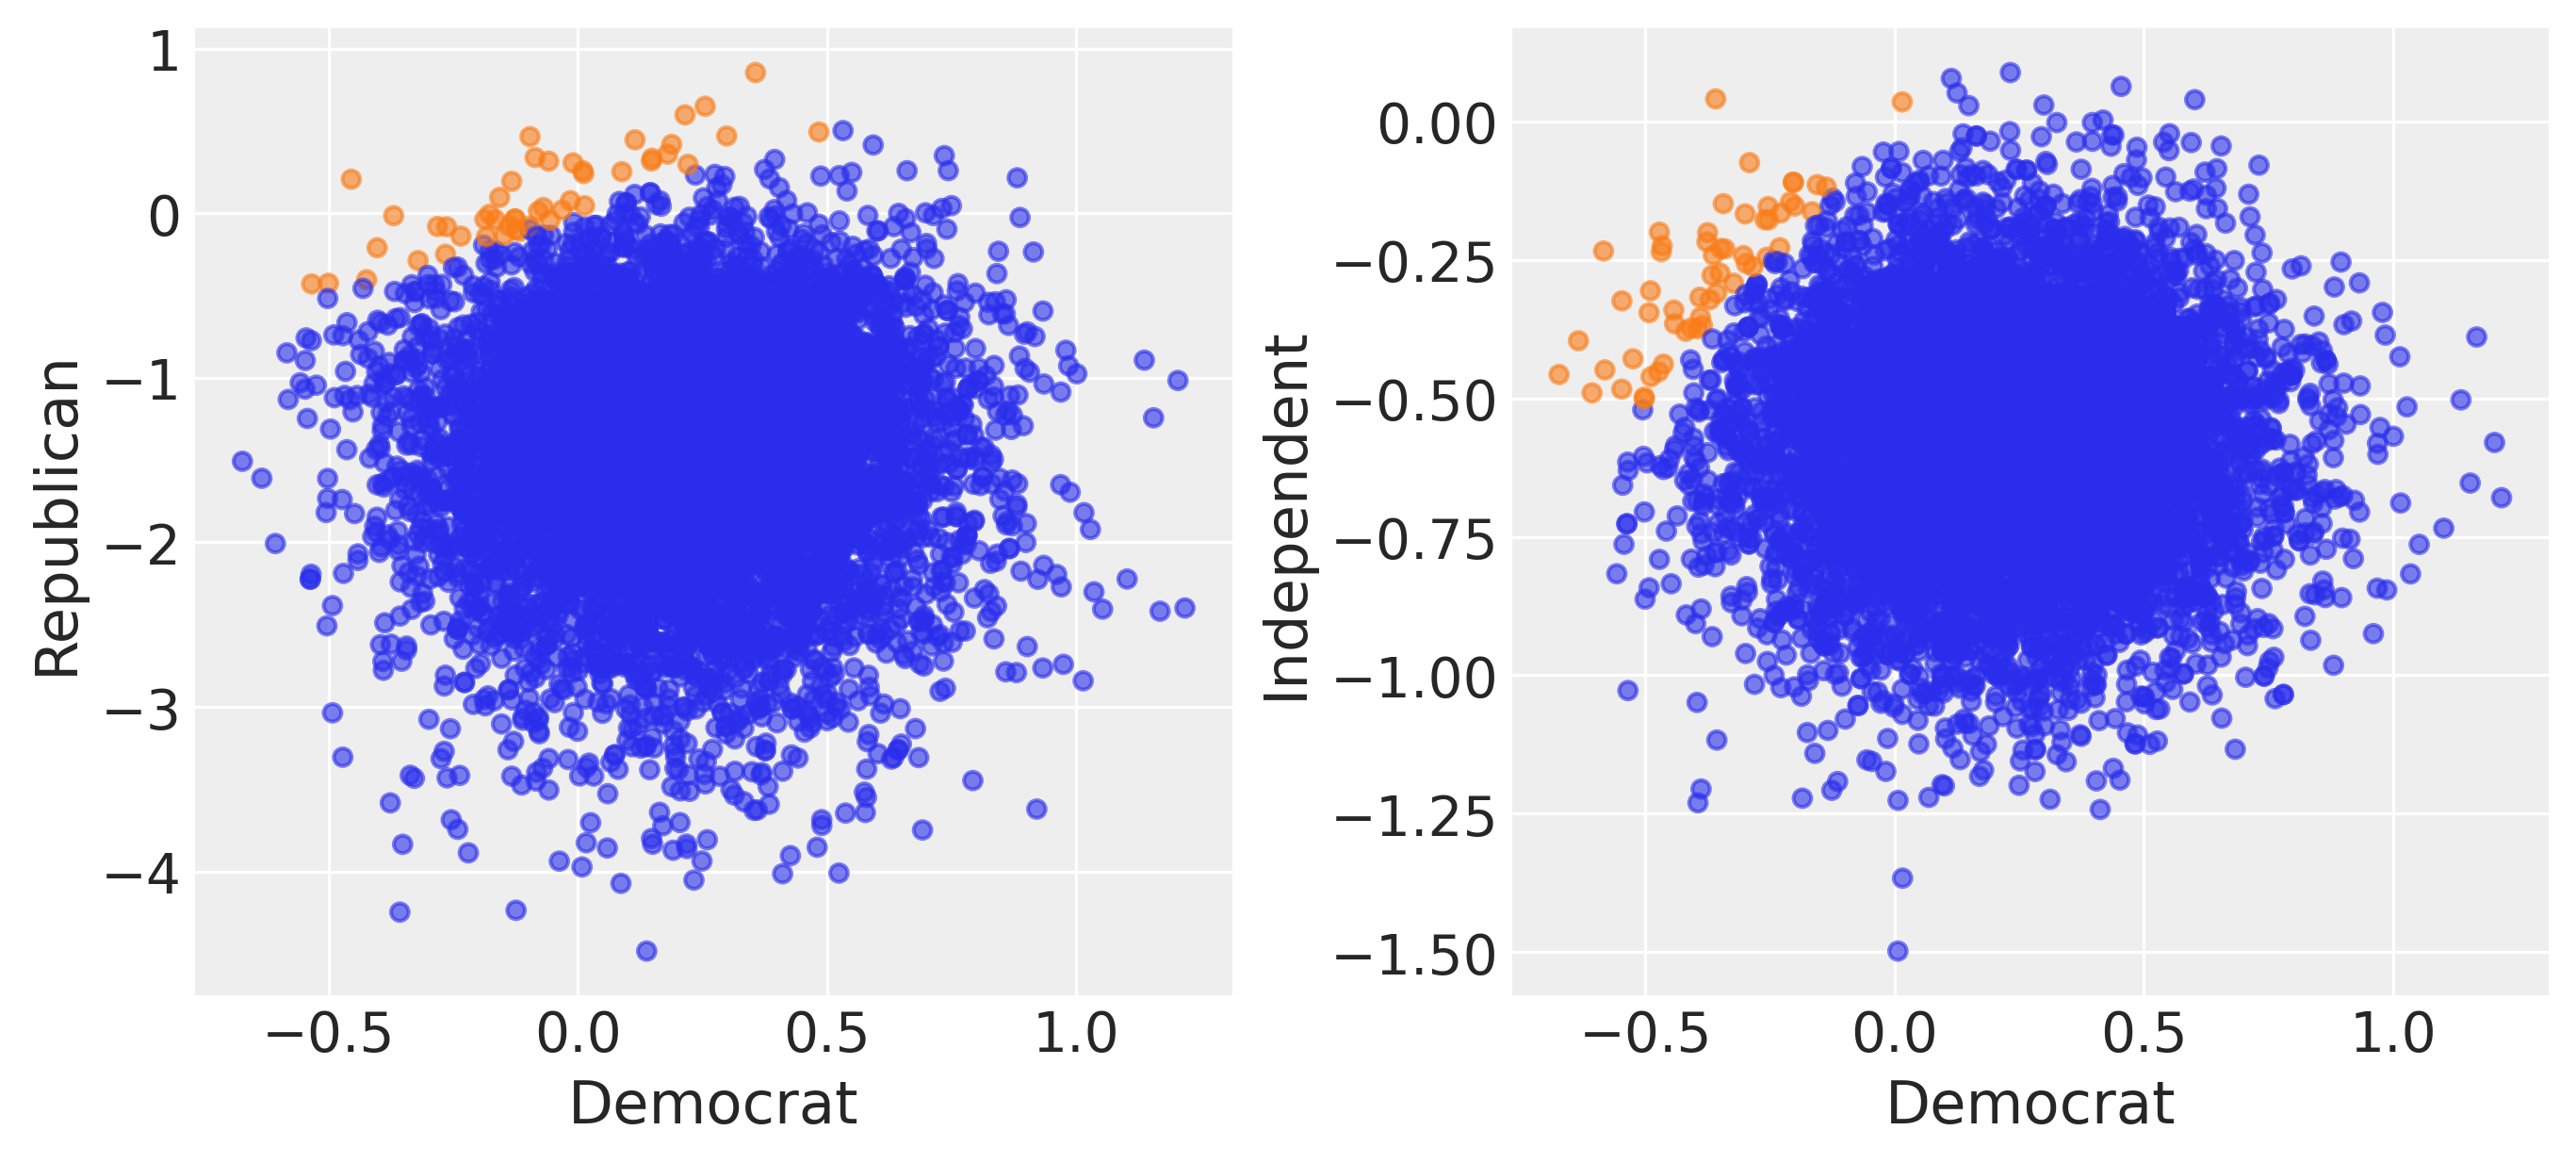

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Just grab first to colors from color map
colors = ["C0" if x > y else "C1" for x, y in zip(dem, rep)]

axes[0].scatter(dem, rep, c=colors, s=20, alpha=0.6)
axes[0].set_xlabel("Democrat")
axes[0].set_ylabel("Republican")

colors = ["C0" if x > y else "C1" for x, y in zip(dem, ind)]

axes[1].scatter(dem, ind, c=colors, s=20, alpha=0.6)
axes[1].set_xlabel("Democrat")
axes[1].set_ylabel("Independent")

fig.savefig("imgs/clinton_party_joint.pdf")   

Blue dots indicate when $\beta_\text{democrat}$ is larger.

## Scaled vs unscaled age

Let's compare sampling time for one model using `scale(age)` and other model using `age`.

In [17]:
model = bmb.Model("vote[clinton] ~ party_id + party_id:scale(age)", data, family="bernoulli")
idata = model.fit(tune=2000, draws=2000, chains=4, random_seed=SEED)
print(idata.posterior.sampling_time)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [party_id:scale(age), party_id, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 25 seconds.


25.1867778301239


In [18]:
model_2 = bmb.Model("vote['clinton'] ~ party_id + party_id:age", data, family="bernoulli")
idata_2 = model_2.fit(tune=2000, draws=2000, chains=4, random_seed=SEED)
print(idata_2.posterior.sampling_time)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [party_id:age, party_id, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 90 seconds.


90.36969876289368


In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w -p formulae

Last updated: Mon May 23 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

formulae: 0.3.4

bambi     : 0.8.0
arviz     : 0.12.0
matplotlib: 3.5.1
numpy     : 1.21.5
pandas    : 1.4.2

Watermark: 2.3.0

